In [70]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append('../model')

In [114]:
import nengo
import numpy as np
import pytry


from eyeblink_motor_system import EyeblinkReflex, Eyelid

def make_lmu(q=6, theta=1.0):
    # Do Aaron's math to generate the matrices
    #  https://github.com/arvoelke/nengolib/blob/master/nengolib/synapses/analog.py#L536
    Q = np.arange(q, dtype=np.float64)
    R = (2*Q + 1)[:, None] / theta
    j, i = np.meshgrid(Q, Q)

    A = np.where(i < j, -1, (-1.)**(i-j+1)) * R
    B = (-1.)**Q[:, None] * R
    return A, B

def add_labels(model, locals):
    
    for k, v in locals.items():
        if isinstance(v, (nengo.Node, nengo.Ensemble)) and v.label is None:
            v.label = k
            
        


class CerebellumTrial(pytry.PlotTrial):
    def params(self):
        self.param('time between trials', period=3.0)
        self.param('time between tone and puff', t_delay=0.1)
        self.param('tone length', t_tone=0.1)
        self.param('puff length', t_puff=0.1)
        self.param('number of trials', n_trials=4)
        self.param('eyelid opening constant', eye_bias=1.5)
        self.param('learning rate', learning_rate=1e-4)
        self.param('q', q=12)
        self.param('only run minimal model', do_minimal=False)
        self.param('theta', theta=0.4)
        self.param('tau for granule', tau=0.1)
        self.param('number of granule cells', n_granule=2000)
        self.param('use cosine intercept distribution', use_cosine=True)
        

    def evaluate(self, p, plt):
        t_tone_start = 0.0
        t_tone_end = t_tone_start + p.t_tone
        t_puff_start = t_tone_end + p.t_delay
        t_puff_end = t_puff_start + p.t_puff
        
        def puff_func(t):
            if t_puff_start < t % p.period < t_puff_end:
                return 1
            else:
                return 0

        def tone_func(t):
            if t_tone_start < t % p.period < t_tone_end:
                return 1
            else:
                return 0

        model = nengo.Network()
        with model:

            ###########################################################################
            # Setup the conditioned stimulus (i.e., a tone) and the unconditioned     #
            # stimulus (i.e., a puff)                                                 #
            ###########################################################################
            nd_tone = nengo.Node(tone_func)
            nd_puff = nengo.Node(puff_func)


            ###########################################################################
            # Setup the reflex generator and the eye-motor system                     #
            ###########################################################################

            # The reflex pathway is across the Trigeminal nucleus in the brainstem;
            # we don't model this in this particular model

            # Scaling factor that has to be applied to the reflex trajectory to scale
            # it to a range from 0 to 1
            reflex_scale = 1.0 / 25.0

            # The reflex system takes an input and produces the reflex trajectory on
            # the rising edge (convolves the differential of the input with the
            # trajectory)
            nd_reflex = nengo.Node(EyeblinkReflex()) # Unscaled output
            nd_reflex_out = nengo.Node(size_in=1)    # Normalised output
            nengo.Connection(nd_reflex[0], nd_reflex_out, transform=reflex_scale,
                             synapse=None)

            if not p.do_minimal:
                # The eyelid component represents the state of the eye in the world.
                # It receives two inputs, an agonist input (closing the eye, dim 0) and an
                # antagonist input (opening the eye, dim 1).
                nd_eyelid = nengo.Node(Eyelid())         # Unscaled input
                eyelid_in = nengo.Ensemble(n_neurons=100, dimensions=2)

                nengo.Connection(eyelid_in, nd_eyelid[0], transform=1.0 / reflex_scale,
                                 function=lambda x: max(x[0], x[1]),
                                 synapse=0.005)

                # Constantly open the eye a little bit
                nd_eye_bias = nengo.Node(p.eye_bias)
                nengo.Connection(nd_eye_bias, nd_eyelid[1])

                # We can't detect the puff if the eye is closed, multiply the output from
                # nd_puff with the amount the eye is opened. This is our unconditioned
                # stimulus
                # NOTE: Currently disabled by commenting out the line below
                c0, c1 = nengo.Node(size_in=1), nengo.Node(size_in=1) # Only for GUI
                nengo.Connection(nd_eyelid, c0, synapse=None)
                nengo.Connection(c0, c1, synapse=None)
            #    nengo.Connection(c1, nd_us[1], synapse=None)

            # Connect the unconditioned stimulus to the reflex generator
            nd_us = nengo.Node(lambda t, x: x[0] * (1 - x[1]), size_in=2, size_out=1)
            nengo.Connection(nd_puff, nd_us[0], synapse=None)
            nengo.Connection(nd_us, nd_reflex)
            if not p.do_minimal:
                nengo.Connection(nd_reflex_out, eyelid_in[0])

            ###########################################################################
            # Generate a neural representation of the conditioned stimulus            #
            ###########################################################################

            nd_cs = nengo.Node(size_in=1)
            ens_pcn = nengo.Ensemble(n_neurons=100, dimensions=1)
            nengo.Connection(nd_tone, nd_cs, synapse=None)
            nengo.Connection(nd_cs, ens_pcn)

            ###########################################################################
            # Generate a LMU representation of the conditioned stimulus               #
            ###########################################################################

            # Create the LTI and transform it into the corresponding NEF LTI
            A, B = make_lmu(q = p.q, theta = p.theta)
            Ap = p.tau*A + np.eye(A.shape[0])
            Bp = B * p.tau

            # Build the LMU, feed the conditioned stimulus into it
            # TODO: Replace with nengo-bio LMU
            ens_granule = nengo.Ensemble(n_neurons=p.n_granule, dimensions=p.q,
                                         intercepts=nengo.dists.CosineSimilarity(p.q+2) if p.use_cosine else nengo.dists.Uniform(-1,1),
                                        )
            nengo.Connection(ens_granule, ens_granule, transform=Ap, synapse=p.tau)
            nengo.Connection(ens_pcn, ens_granule, transform=Bp, synapse=p.tau)

            ###########################################################################
            # Learn the connection from the Granule cells to the Purkinje cells via   #
            # input from the Interior Olive                                           #
            ###########################################################################

            # This is the US pathway; the data is relayed from the Trigeminal nucleus
            # to the Interior Olive.

            ens_cn = nengo.Ensemble(n_neurons=100, dimensions=1)
            ens_io = nengo.Ensemble(n_neurons=100, dimensions=1)
            ens_purkinje = nengo.Ensemble(n_neurons=100, dimensions=1)

            # Represent the error signal in ens_io
            nengo.Connection(nd_reflex_out[0], ens_io, transform=-1)
            nengo.Connection(ens_cn, ens_io, transform=1) # This connection does not exist

            # Project from the 
            c_learn = nengo.Connection(
                ens_granule.neurons, ens_purkinje,
                transform=np.zeros((ens_purkinje.dimensions, ens_granule.n_neurons)),
                learning_rule_type=nengo.learning_rules.PES(learning_rate=p.learning_rate))
            nengo.Connection(ens_io, c_learn.learning_rule)

            ###########################################################################
            # Project from CN onto the motor system
            ###########################################################################

            nengo.Connection(ens_purkinje, ens_cn)
            if not p.do_minimal:            
                nengo.Connection(ens_cn, eyelid_in[1])
            
            p_nd_reflex_out = nengo.Probe(nd_reflex_out)
            if not p.do_minimal:
                p_eyelid = nengo.Probe(nd_eyelid)
            p_purkinje = nengo.Probe(ens_purkinje, synapse=0.03)
            p_granule = nengo.Probe(ens_granule, synapse=0.03)
            
        add_labels(model, locals=locals())
        
        sim = nengo.Simulator(model)
        with sim:
            sim.run(p.period*p.n_trials)
            
            
            
        if plt:
            dt = 0.001
            steps = int(p.period/dt)
            t = np.arange(steps)*dt
            
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,9))
            
            cmap = matplotlib.cm.get_cmap("viridis")
            for i in range(0, sim.n_steps, steps):
                color = cmap(i / sim.n_steps)
                #if not p.do_minimal:                    
                #    ax1.plot(t, sim.data[p_eyelid][i:i+steps], label='eyelid %d'%(i//steps), ls='--')
                ax2.plot(t, sim.data[p_purkinje][i:i+steps], color=color)
                ax3.plot(t, np.cumsum(np.abs(sim.data[p_purkinje][i:i+steps]))*dt/reflex_scale, color=color)
            ax1.plot(t, sim.data[p_granule][i:i+steps])
            ax2b = ax2.twinx()
            ax2b.plot(t, sim.data[p_nd_reflex_out][i:i+steps], c='k', ls='--')
        
        return dict(model=model)


running CerebellumTrial#20200117-183330-60268971
Building finished in 0:00:01.                                                   
Simulating finished in 0:05:32.                                                 
seed = 1
period = 0.8
t_delay = 0.1
t_tone = 0.1
t_puff = 0.1
n_trials = 300
eye_bias = 4
learning_rate = 0.0001
q = 3
do_minimal = True
theta = 0.4
tau = 0.1
n_granule = 500
use_cosine = True
model = <Network (unlabeled) at 0x7f38ac2c2668>


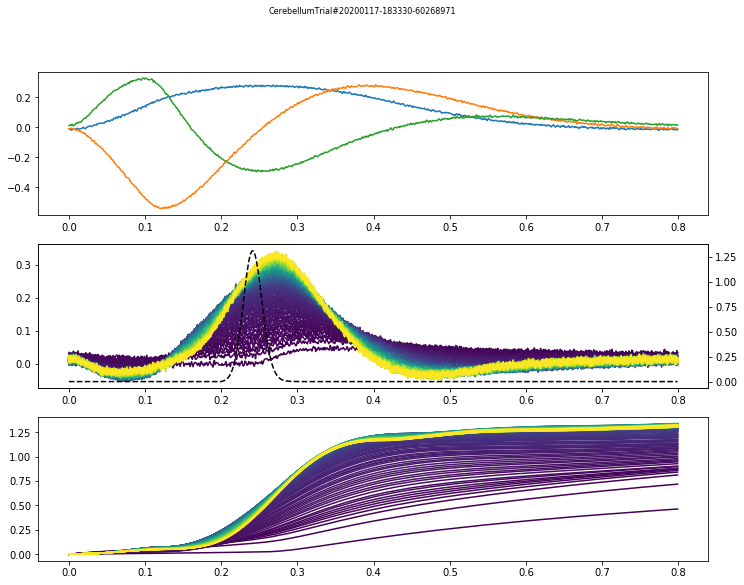

In [119]:
r = CerebellumTrial().run(plt=plt, period=0.8, eye_bias=4, data_dir=None, learning_rate=1e-4, 
                          q=3, n_trials=300, n_granule=500, tau=0.1,
                          do_minimal=True)

In [69]:
import nengo_gui.jupyter
model = r['model']
nengo_gui.jupyter.InlineGUI(model)
